<a href="https://colab.research.google.com/github/ReddySameer/tensorflow/blob/main/06_transferlearning_in_tensorflow_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning in Tensorflow - Scale Up

In [1]:
!nvidia-smi

Fri May 31 12:50:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-31 12:50:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-31 12:50:30 (78.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [4]:
# import helper functions

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2024-05-31 12:50:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  21.8MB/s    in 73s     

2024-05-31 12:51:56 (21.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
unzip_data("101_food_classes_10_percent.zip")

In [7]:
train_dir="101_food_classes_10_percent/train"
test_dir="101_food_classes_10_percent/test"

In [8]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/filet_mignon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/carrot_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/omelette'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in '101_food_class

In [10]:
import tensorflow as tf

In [11]:

IMG_SIZE=(224,224)
train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE)

test_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Transfer learning on 10% of 101 food classes

1. Create a modelcheclpoint callback
2. create Data augmentation layer to build data augmentation in to the model
3. Build headless (no top layers) Functional EfficeintNetB0 backboned model
4. Compile the model
5. Extract for 5 full passes (5 epochs on train dataset) and validate on the 15% of test data

In [9]:
# Create Checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
# checkpoint argument `monitor val_loss`  used in conjunction with save_best_only, when the save_best_only is True, it will record the val_loss that is very low
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint (checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)

In [12]:
# Create Data Augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential



In [15]:
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1/255.) # efficient NetB0 has Rescaling built in for images to between 0 and 1, but is required for models like Resnet
], name="data_augmentation")

# Tranfer learning feature extraction model

In [16]:
# Setup the base model and freeze its layers, (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # incude_top=False, to avoid top layers
base_model.trainable=False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # this puts the base model in inference mode, so weights are frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x) # for layers, the inputs go outside the function method here: ..) (x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer") (x)
model = tf.keras.Model(inputs, outputs)

In [17]:
# Get Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 224, 3)      0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [18]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [15]:
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
          epochs=5,
          #steps_per_epoch=
          validation_data=test_data_all_10_percent,
          validation_steps=int(0.15 * len(test_data_all_10_percent)),
          callbacks=[checkpoint_callback]
          )

Epoch 1/5
237/237 [==============================] - 78s 280ms/step - loss: 3.4344 - accuracy: 0.2598 - val_loss: 2.3100 - val_accuracy: 0.4714
Epoch 2/5
237/237 [==============================] - 47s 197ms/step - loss: 2.2401 - accuracy: 0.4924 - val_loss: 1.8567 - val_accuracy: 0.5373
Epoch 3/5
237/237 [==============================] - 31s 128ms/step - loss: 1.8749 - accuracy: 0.5542 - val_loss: 1.6895 - val_accuracy: 0.5659
Epoch 4/5
237/237 [==============================] - 29s 123ms/step - loss: 1.6385 - accuracy: 0.6003 - val_loss: 1.5989 - val_accuracy: 0.5808
Epoch 5/5
237/237 [==============================] - 31s 126ms/step - loss: 1.4843 - accuracy: 0.6376 - val_loss: 1.5654 - val_accuracy: 0.5871


In [13]:
feature_extraction_results = fine_tuning_results=model.evaluate(test_data_all_10_percent);
feature_extraction_results

NameError: name 'model' is not defined

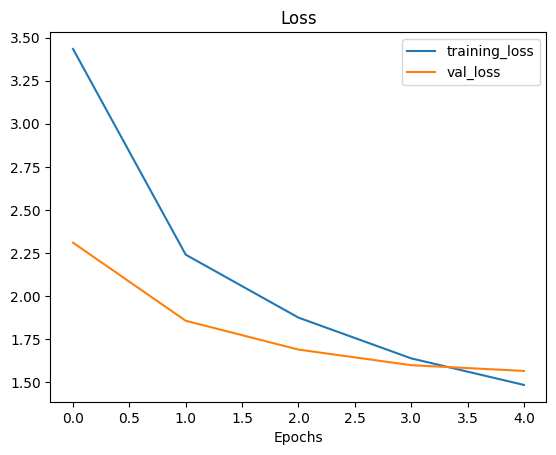

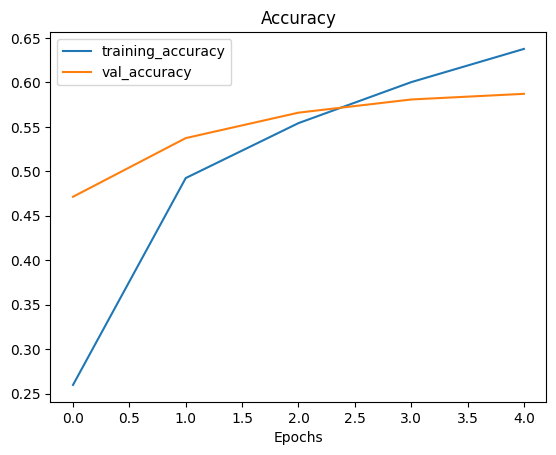

In [17]:
plot_loss_curves(history_all_classes_10_percent)

# The two curves must be very similar to each other, it it is not, then it may suggest that the model is overfitting (performing toowell on teh training data and not genalizing on the unseen data)

#Fine Tune the layers

Unfreeze all of the layes in the base model


In [19]:
#To unfreeze
base_model.trainable = True
#Refreeze  every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [20]:
# REcompile the model to lower the learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10% to improve(to reduce loss) the loss function
              metrics=["accuracy"])

In [21]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [22]:
for layer_number, layer in enumerate(base_model.layers) :
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

# Fine tuning not always necessary to improve the results

In [22]:
fine_tune_epochs = 10 # already trained 5 so next is 10
history_all_classes_10_percent_Fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data_all_10_percent,
                                                     validation_steps=int(0.15 * len(test_data_all_10_percent)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # to continue training from where it last did

Epoch 5/10
237/237 [==============================] - 40s 126ms/step - loss: 1.2516 - accuracy: 0.6766 - val_loss: 1.4893 - val_accuracy: 0.5998
Epoch 6/10
237/237 [==============================] - 30s 125ms/step - loss: 1.1377 - accuracy: 0.6957 - val_loss: 1.4726 - val_accuracy: 0.6062
Epoch 7/10
237/237 [==============================] - 28s 117ms/step - loss: 1.0491 - accuracy: 0.7203 - val_loss: 1.4822 - val_accuracy: 0.6075
Epoch 8/10
237/237 [==============================] - 28s 118ms/step - loss: 0.9989 - accuracy: 0.7368 - val_loss: 1.4728 - val_accuracy: 0.6075
Epoch 9/10
237/237 [==============================] - 29s 120ms/step - loss: 0.9140 - accuracy: 0.7552 - val_loss: 1.4813 - val_accuracy: 0.6094
Epoch 10/10
237/237 [==============================] - 30s 123ms/step - loss: 0.8777 - accuracy: 0.7659 - val_loss: 1.4827 - val_accuracy: 0.6112


In [23]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data_all_10_percent)

790/790 [==============================] - 62s 78ms/step - loss: 1.4981 - accuracy: 0.6018


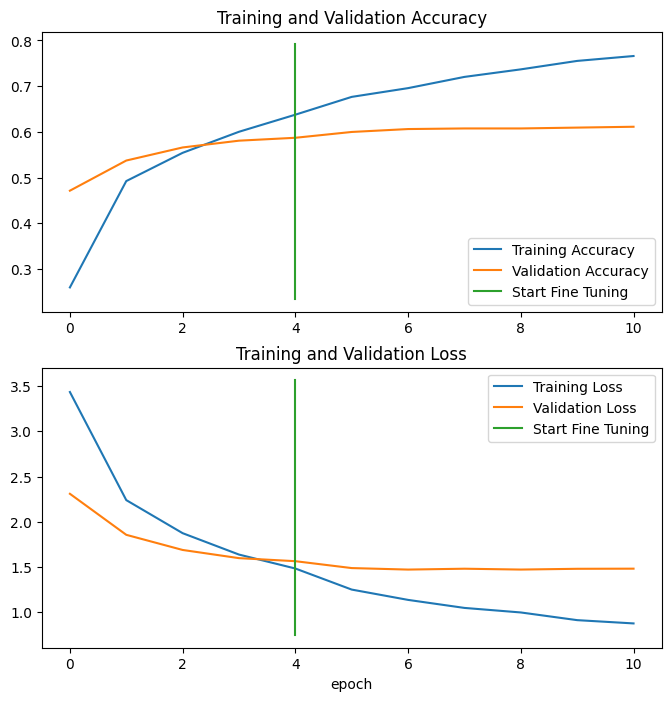

In [25]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_Fine_tune,
                 initial_epochs=5)

#To use the model in an external application, then save and export it

In [26]:
model.save("drive/MyDrive/tensorflow_course101_food_classes_10_percent_saved_bigdata_model")

In [23]:
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course101_food_classes_10_percent_saved_bigdata_model")

In [24]:
#evaluate loaded model and compare results with presaved model
loaded_model_results = loaded_model.evaluate(test_data_all_10_percent)
loaded_model_results

790/790 [==============================] - 67s 78ms/step - loss: 1.4981 - accuracy: 0.6018


[1.498116374015808, 0.601821780204773]

In [25]:
all_classes_10_percent_Fine_tune_results

NameError: name 'all_classes_10_percent_Fine_tune_results' is not defined

# evaluate the performance of the big data model across all the different classes

In [56]:
 import tensorflow as tf

 # Download pretrained model

 !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-05-31 13:27:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M  14.0MB/s    in 3.2s    

2024-05-31 13:27:34 (14.0 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [57]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [58]:
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [59]:
# Evaluate Loaded Model
results_downloaded_model = model.evaluate(test_data_all_10_percent)
results_downloaded_model

790/790 [==============================] - 62s 76ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027218580245972, 0.6077623963356018]

# MAking PRedictions with the trained model

In [60]:
preds_probs = model.predict(test_data_all_10_percent, verbose=1)
preds_probs[0]

790/790 [==============================] - 64s 79ms/step


array([5.5881810e-11, 5.6855850e-08, 4.0038518e-11, 1.6734222e-01,
       4.0055940e-07, 9.6075013e-02, 1.3993500e-12, 1.2694558e-04,
       2.7759631e-12, 7.8876887e-09, 5.8694175e-03, 2.9581168e-03,
       2.6033392e-11, 3.6984376e-05, 6.1896571e-08, 2.0035806e-03,
       6.4790257e-08, 1.6375771e-11, 6.9072285e-06, 3.0163093e-04,
       1.5667196e-08, 1.1974504e-08, 3.4018937e-09, 4.2062333e-11,
       7.3302071e-09, 5.2590035e-06, 3.9436065e-02, 1.7464905e-10,
       1.7547535e-04, 3.3376125e-11, 9.4946724e-11, 3.7687986e-10,
       7.0361261e-07, 7.9050155e-11, 6.3286774e-07, 2.0019253e-07,
       8.9084206e-04, 3.7554940e-04, 3.3709448e-11, 3.3147735e-11,
       1.9397088e-09, 8.9113835e-13, 7.2952842e-12, 2.5069522e-07,
       7.5149927e-03, 3.3336601e-08, 4.1421200e-11, 8.9482864e-04,
       5.3056550e-01, 1.3797187e-09, 2.8904544e-06, 4.1790812e-05,
       7.4419859e-07, 5.5095541e-08, 1.7432318e-07, 8.4052254e-10,
       2.7063390e-06, 4.5031104e-08, 3.3063978e-09, 2.1242351e

In [61]:
len(test_data_all_10_percent), len(test_data_all_10_percent) * 32 #data count

(790, 25280)

In [63]:
len(preds_probs)

25250

In [62]:
preds_probs.shape # shoudl get (25250, 101 ),  101 classes , 25250 images

(25250, 101)

# Explore the first 10 predictions look like

In [64]:
preds_probs[:10], len(preds_probs[0])

(array([[5.5881810e-11, 5.6855850e-08, 4.0038518e-11, ..., 8.0498316e-12,
         2.9519363e-06, 3.3100798e-07],
        [1.8412166e-04, 6.2416220e-08, 1.4374459e-04, ..., 9.6906012e-01,
         4.7016729e-07, 5.8991909e-03],
        [6.6702314e-06, 2.5756925e-04, 3.9259227e-08, ..., 4.7997119e-08,
         4.6755039e-07, 8.2564005e-04],
        ...,
        [1.2073005e-04, 2.2211841e-04, 2.9398419e-04, ..., 3.1136304e-05,
         2.8071433e-06, 1.1887265e-05],
        [5.2559747e-13, 4.0604952e-13, 1.6270203e-13, ..., 8.2425983e-11,
         1.2169160e-14, 1.4755914e-11],
        [5.9941434e-03, 2.6324447e-08, 3.5202802e-06, ..., 1.0841674e-05,
         1.0039593e-06, 3.6049352e-03]], dtype=float32),
 101)

In [65]:
# What does the first prediction probabilty array look like

preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])   # the sum of the preds_probs[0] should be close to 1.

(array([5.5881810e-11, 5.6855850e-08, 4.0038518e-11, 1.6734222e-01,
        4.0055940e-07, 9.6075013e-02, 1.3993500e-12, 1.2694558e-04,
        2.7759631e-12, 7.8876887e-09, 5.8694175e-03, 2.9581168e-03,
        2.6033392e-11, 3.6984376e-05, 6.1896571e-08, 2.0035806e-03,
        6.4790257e-08, 1.6375771e-11, 6.9072285e-06, 3.0163093e-04,
        1.5667196e-08, 1.1974504e-08, 3.4018937e-09, 4.2062333e-11,
        7.3302071e-09, 5.2590035e-06, 3.9436065e-02, 1.7464905e-10,
        1.7547535e-04, 3.3376125e-11, 9.4946724e-11, 3.7687986e-10,
        7.0361261e-07, 7.9050155e-11, 6.3286774e-07, 2.0019253e-07,
        8.9084206e-04, 3.7554940e-04, 3.3709448e-11, 3.3147735e-11,
        1.9397088e-09, 8.9113835e-13, 7.2952842e-12, 2.5069522e-07,
        7.5149927e-03, 3.3336601e-08, 4.1421200e-11, 8.9482864e-04,
        5.3056550e-01, 1.3797187e-09, 2.8904544e-06, 4.1790812e-05,
        7.4419859e-07, 5.5095541e-08, 1.7432318e-07, 8.4052254e-10,
        2.7063390e-06, 4.5031104e-08, 3.3063978e

As we discussed before, for each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer (layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax"), it outputs a prediction probability between 0 and 1 for all each of the 101 classes.

And the index of the highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probaiblity value, the less the model thinks that the target image is that specific class.

🔑 Note: Due to the nature of the softmax activation function, the sum of each of the prediction probabilities for a single sample will be 1 (or at least very close to 1). E.g. pred_probs[0].sum() = 1.

In [45]:
# we get one prediction probability per class out of 101 classes
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"what is the prediction probabilities for sample 0: \n { (preds_probs[0])}")


Number of prediction probabilities for sample 0: 101
what is the prediction probabilities for sample 0: 
 [1.90614321e-12 4.14632157e-16 5.15919685e-12 1.47222342e-19
 3.08920360e-17 5.99249993e-14 1.10382811e-17 1.23355263e-18
 6.81655633e-13 5.21784628e-14 1.46045057e-17 1.88141132e-16
 3.67804355e-12 1.57676910e-18 2.00843953e-13 2.95717292e-12
 4.29646162e-12 2.53197067e-13 1.43712361e-16 4.24036847e-12
 1.34746150e-13 2.05025694e-13 1.92297762e-12 5.70338395e-12
 1.13390295e-11 1.29576627e-14 1.23972135e-13 9.48825220e-13
 1.84173868e-15 7.42652029e-09 2.69936254e-14 7.70571029e-15
 9.99999881e-01 3.73304022e-14 8.94035714e-13 3.84992548e-13
 1.76631984e-13 2.13199159e-16 2.98066738e-16 2.27013533e-15
 2.02851194e-14 5.36662423e-14 5.66914662e-15 2.84155916e-16
 2.05669178e-17 1.96195802e-14 4.36903050e-14 2.39842541e-16
 3.38713785e-16 2.98511796e-15 1.00542093e-13 6.33900029e-16
 1.20075087e-11 1.90756716e-14 1.06554950e-17 2.82213445e-17
 1.30497165e-16 1.15824733e-07 1.2796173

In [66]:
print(f"The class with the highest prediction probability for sample: {preds_probs[0].argmax()}")
preds_probs[0]

The class with the highest prediction probability for sample: 48


array([5.5881810e-11, 5.6855850e-08, 4.0038518e-11, 1.6734222e-01,
       4.0055940e-07, 9.6075013e-02, 1.3993500e-12, 1.2694558e-04,
       2.7759631e-12, 7.8876887e-09, 5.8694175e-03, 2.9581168e-03,
       2.6033392e-11, 3.6984376e-05, 6.1896571e-08, 2.0035806e-03,
       6.4790257e-08, 1.6375771e-11, 6.9072285e-06, 3.0163093e-04,
       1.5667196e-08, 1.1974504e-08, 3.4018937e-09, 4.2062333e-11,
       7.3302071e-09, 5.2590035e-06, 3.9436065e-02, 1.7464905e-10,
       1.7547535e-04, 3.3376125e-11, 9.4946724e-11, 3.7687986e-10,
       7.0361261e-07, 7.9050155e-11, 6.3286774e-07, 2.0019253e-07,
       8.9084206e-04, 3.7554940e-04, 3.3709448e-11, 3.3147735e-11,
       1.9397088e-09, 8.9113835e-13, 7.2952842e-12, 2.5069522e-07,
       7.5149927e-03, 3.3336601e-08, 4.1421200e-11, 8.9482864e-04,
       5.3056550e-01, 1.3797187e-09, 2.8904544e-06, 4.1790812e-05,
       7.4419859e-07, 5.5095541e-08, 1.7432318e-07, 8.4052254e-10,
       2.7063390e-06, 4.5031104e-08, 3.3063978e-09, 2.1242351e

In [36]:
test_data_all_10_percent.class_names[32]

'dumplings'

In [67]:
# Get the pred classes for each label
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([48, 98, 34, 21, 14, 31, 17, 37, 23, 34])

In [68]:
len(pred_classes)

25250

In [ ]:
# compare the actual classes to the pred_classes - compare them to the original test data set labels

In [46]:
len(test_data_all_10_percent)

790

# To get the test labels, unravel the test_Data batchDataset



In [47]:
test_data_all_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [69]:
y_labels = []

for images, labels in test_data_all_10_percent.unbatch(): # unbatch the dataset
  y_labels.append(labels.numpy().argmax()) # do argmax because the test labels look like 0, 0, 0, ...1..0,0 where the class label is present will have 1

y_labels[:1]

[57]

In [52]:
y_labels[:10], pred_classes

([24, 0, 54, 75, 94, 89, 9, 57, 54, 14], array([81, 20, 88, ..., 91, 70, 79]))

In [45]:
images[0][0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([162.05103, 146.33673, 126.15306], dtype=float32)>

In [52]:
len(y_labels) # how many ylabel are present

25250

# Evaluate the predictions

* Check the accuracy Scores

In [73]:
results_downloaded_model, len(pred_classes), len(y_labels)

([1.8027218580245972, 0.6077623963356018], 25250, 25250)

# Use Scikit learn accuracy_score

In [70]:
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.011445544554455445

In [71]:
# Does this metric come close to the models evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

# should return true ..but is returning false, the predclasses need to be 0/1

False

In [ ]:
from helper_functions import make_confusion_matrix

make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)


# MAke Confusion metrix

In [84]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [74]:
#from helper_functions import make_confusion_matrix

In [83]:
class_names = test_data_all_10_percent.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [85]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

LEft all the plotting .. need to do this

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.02      0.01      0.01       250
           1       0.01      0.02      0.01       250
           2       0.01      0.01      0.01       250
           3       0.01      0.00      0.00       250
           4       0.01      0.00      0.01       250
           5       0.02      0.03      0.02       250
           6       0.01      0.02      0.01       250
           7       0.01      0.01      0.01       250
           8       0.01      0.01      0.01       250
           9       0.01      0.00      0.00       250
          10       0.01      0.00      0.00       250
          11       0.00      0.00      0.00       250
          12       0.01      0.01      0.01       250
          13       0.01      0.01      0.01       250
          14       0.00      0.00      0.00       250
          15       0.01      0.00      0.00       250
          16       0.01      0.02      0.01       250
          17       0.01    

Precision - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
Recall - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
F1 score - Combines precision and recall into one metric. 1 is best, 0 is worst.

In [ ]:

# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict


#198. Visualize predictions on test images

* Read in a target image filepath using tf.io.read_file()
* trun the image into a Tensor using tf.io.decode_image()
* Resize the image  tensor to be the same size as the images the model has trained on using tf.

In [2]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  reads an image from a file, turns it intoa a Tensor and reshapes that into
   a specified shape (img_shape, img_hsape, color_Channels=3

  Args:
    filename(str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1

  Returns:
    Image Tensor of shape(img_shape, img_shape, 3)
  """
  #read the image
  img = tf.io.read_file(filename)

  # Decode image tino the tensor
  img = tf.io.decode_image(img, channels=3)

  #resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  #Scale? yes or no
  if scale:
    return img/255.
  else:
    return img # dont have to rescale image in EfficientNet models

# Visualize Images, labels and the models predictions

1. load a few random images
2. Make predictions on the loaded images
3. plot the original images with the models predictions, prediction probability,

In [3]:
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name= random.choice(class_names)
  filename =random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  print(filepath)

  # load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  print(img_expanded.shape)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]
  print(pred_prob)
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if( class_name == pred_class): # if predicted class matches the truth class makr text green
    title_color="g"
  else:
    title_color="r"
  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():0.2f} c={title_color}")
  plt.axis(False);

In [4]:
import random
random.choice(class_names)

NameError: name 'class_names' is not defined

# Finding the most wrong predictions

1. GEt all the image filepaths in the test datasets using list_files()
2. Create a pandas Dataframe, of the image filepaths, ground truth labels, predicted classes (from our model) max prediction probablities, prediction class names, and ground truth class names
3. Use the DataFrame to find all the wrong predictions (where the groufn truth labels dont match the predictions)
4. Sort the DataFrame based on wrong predictions (have the highest probability predictions at the top)
5. Visualize the images with the highest prediction probabilities but have the wrong prediction


In [ ]:
# 1. list file files
filepaths = []
for filepath in test_data_all_10_percent.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepath.append(filepath.numpy())

filepaths[:10]


In [ ]:
# 2. Create the DataFrames of the image filepaths
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                       "y_true": y_labels,
                       "y_pred": pred_classes,
                       "pred_conf": pred_probs.max(axis=1), # pred_conf - > prediction confidence, get the maximum prediction value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] in i in pred_classes]
                        })

In [ ]:
pred_df

In [ ]:
pred_classes

In [ ]:
[class_names[i] for i in y_labels[:10]]

In [ ]:
# 3. USe the dataFrame to find all the wrong predictions
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head

# 4. Sort the dataFrame based on the Wrong Predictions



In [ ]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

In [ ]:
# 5. Visualize teh images with the highest prediction probabilities but have the wrong prediction

images_to_view=9
start_index = 0
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index: start_index+images_to_view].itertupes()):  # enumerate over 0 to 9
  #print(row)
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # print only the few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}, \n
  prob: {pred_prob}")
  plt.axis(False)



# Test the big dog model on custom images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

In [ ]:
unzip_data("custom_food_images.zip")

In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in ol.kistdir("custom_food_images")]
custom_food_images

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # no need to scale for EfficientNet as it does itself
  pred_prob = model.predict(tf.expand_dims(img, axis=0))  # make prediction with shape [1, 224, 224, 3] same shape as the train images
  pred_class = class_names[pred_prob.argmax()]
  # plot the appropriate information

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred:{pred_class}, prob: {pred_prob.max(): .2f}")
  plt.axis(False)
